In [1]:
import torch
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import bliss

import bliss.models.encoder as encoder_lib
from bliss.models.decoder import ImageDecoder
from bliss.models import galaxy_net

from bliss import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cuda
True


In [3]:
torch.manual_seed(2342)
np.random.seed(354)

# Model parameters

In [4]:
# create training dataset
n_bands = 2
slen = 8

tile_slen = 2

In [5]:
# background
background = torch.zeros(n_bands, slen, slen, device=device)
background[:] = 686.0

In [6]:
# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")
psf_params = torch.from_numpy(np.load(psf_file)).to(device)[0:n_bands]

### Get galaxy decoder

In [7]:
# there is only a single-band galaxy decoder. 
# if n_bands > 1 turn off galaxies
if n_bands == 1: 
    gal_slen = 51
    latent_dim = 8
    decoder_file = '../data/galaxy_decoder_1_band.dat'
    dec = galaxy_net.CenteredGalaxyDecoder(gal_slen, latent_dim, n_bands=n_bands).to(device)
    dec.load_state_dict(torch.load(decoder_file, map_location=device))
    dec.eval()
    prob_galaxy = 0.5
else: 
    dec = None
    prob_galaxy = 0.

# Define decoder

In [8]:
# false for debugging
add_noise = False

In [9]:
slen

8

In [10]:
tile_slen

2

In [11]:
image_decoder = ImageDecoder(dec,
                        psf_params,
                        background,
                        n_bands=n_bands,
                        slen=slen,
                        tile_slen=tile_slen,
                        prob_galaxy=prob_galaxy,
                        max_sources_per_tile=4,
                        mean_sources_per_tile=0.8,
                        min_sources_per_tile=0,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=add_noise)

# Sample parameters

In [12]:
batch_size = 3

In [13]:
params = image_decoder.sample_parameters(batch_size)

In [31]:
params['fluxes'].shape

torch.Size([3, 16, 4, 2])

### check patterns of parameters 

In [15]:
for i in range(params['n_sources'].shape[0]): 
    for j in range(params['n_sources'].shape[1]): 
        
        n_sources_ij = params['n_sources'][i, j]
        is_on_array_ij = torch.zeros(image_decoder.max_sources_per_tile).to(device)
        is_on_array_ij[0:n_sources_ij] = 1
        
        # check locs
        locs_ij = params['locs'][i, j]
        assert torch.all(locs_ij[0:n_sources_ij] != 0)
        assert torch.all(locs_ij[n_sources_ij:] == 0)
        
        # check fluxes
        fluxes_ij = params['fluxes'][i, j]
        is_star = (params['galaxy_bool'][i,j] == 0)
        is_star = (is_on_array_ij == 1) & is_star
        assert torch.all(fluxes_ij[is_star] != 0)
        assert torch.all(fluxes_ij[~is_star] == 0)
        
        # check log-fluxes
        log_fluxes_ij = params['log_fluxes'][i, j]
        assert torch.all(log_fluxes_ij[is_star] != 0)
        assert torch.all(log_fluxes_ij[~is_star] == 0)
        
        # check galaxy parameters
        galaxy_params_ij = params["galaxy_params"][i,j]
        is_galaxy = (params['galaxy_bool'][i,j] == 1)
        is_galaxy = (is_on_array_ij == 1) & is_galaxy
        assert torch.all(galaxy_params_ij[is_galaxy] != 0)
        assert torch.all(galaxy_params_ij[~is_galaxy] == 0)
        
        # check counts 
        assert params['n_stars'][i,j] == is_star.sum()
        assert params['n_galaxies'][i,j] == is_galaxy.sum()

# Construct p-tiles

In [17]:
# this is just for debugging: 
# set to some easily visualize-able parameter values
constant_flux = True
if constant_flux: 
    params['fluxes'][params['fluxes'] != 0] = 1e5
    
constant_locations = True
if constant_locations: 
    params['locs'][params['locs'] != 0] = 0.5 / tile_slen

In [18]:
image_ptiles = image_decoder.render_ptiles(
                            params['n_sources'],
                            params['locs'],
                            params['galaxy_bool'],
                            params['galaxy_params'],
                            params['fluxes'])


In [19]:
# this is batchsize x n_tiles_per_image x n_bands x ptile_slen x ptile_slen
image_ptiles.shape

torch.Size([3, 16, 2, 10, 10])

### Plot tiles from one batch

In [20]:
%matplotlib inline  

In [21]:
batch = 1
band = 0

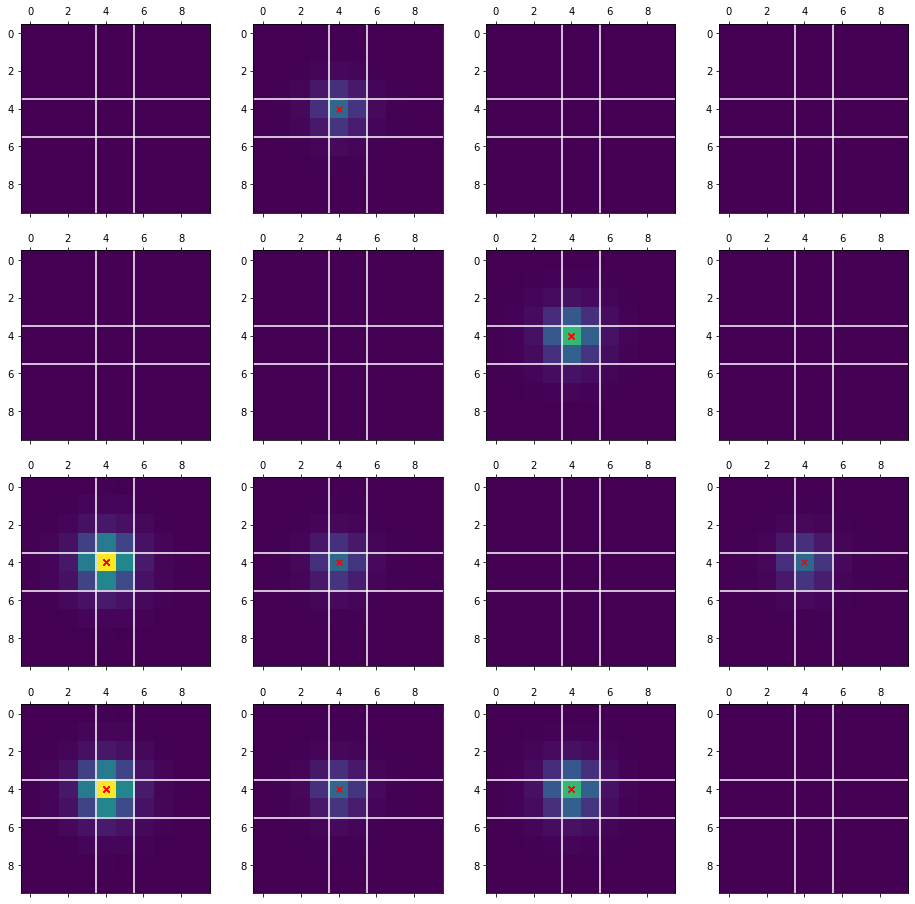

In [22]:
# for plotting 
padding = (image_decoder.ptile_slen - image_decoder.tile_slen) / 2 - 0.5

n_tiles1 = int(slen / tile_slen)
f, axarr = plt.subplots(n_tiles1, n_tiles1, figsize=(16, 16))


vmax = image_ptiles[batch, :, band].abs().max()
vmin = image_ptiles[batch, :, band].abs().min()

for j in range(image_ptiles.shape[1]): 
    ax = axarr[j // n_tiles1, j % n_tiles1]
    ax.matshow(image_ptiles[batch, j, band].detach().cpu(), 
               vmax = vmax, vmin = vmin)

    # plot locations
    n_sources = int(params["n_sources"][batch, j])
    if n_sources > 0:
        galaxy_bool = params["galaxy_bool"][batch, j]
        is_on_bool = torch.arange(image_decoder.max_sources_per_tile) < n_sources

        # plot stellar locations 
        is_star = (galaxy_bool == 0).cpu() & (is_on_bool == 1).cpu()
        ax.scatter(params['locs'][batch, j, is_star, 1].cpu() * image_decoder.tile_slen + padding, 
                    params['locs'][batch, j, is_star, 0].cpu() * image_decoder.tile_slen + padding, 
                   color = 'r', marker = 'x')

        # plot galaxy locations 
        is_galaxy = (galaxy_bool == 1).cpu() & (is_on_bool == 1).cpu()
        ax.scatter(params['locs'][batch, j, is_galaxy, 1].cpu() * image_decoder.tile_slen + padding, 
                    params['locs'][batch, j, is_galaxy, 0].cpu() * image_decoder.tile_slen + padding, 
                   color = 'g', marker = 'x')
        
    # plot tile borders
    ax.axvline(padding, color = 'white')
    ax.axvline(padding + tile_slen, color = 'white')
    ax.axhline(padding, color = 'white')
    ax.axhline(padding + tile_slen, color = 'white')
    

# Now construct the full image from the ptiles

In [23]:
images = image_decoder.render_images(
                            params['n_sources'],
                            params['locs'],
                            params['galaxy_bool'],
                            params['galaxy_params'],
                            params['fluxes'])


In [24]:
# get full-image parameterization
n_sources_full, locs_full, galaxy_params_full, fluxes_full = \
    encoder_lib._get_full_params_from_sampled_params(
                                                    slen,
                                                    tile_slen,
                                                    params['n_sources'],
                                                    params['locs'], 
                                                    params['galaxy_params'], 
                                                    params['fluxes'])

### Plot full image!

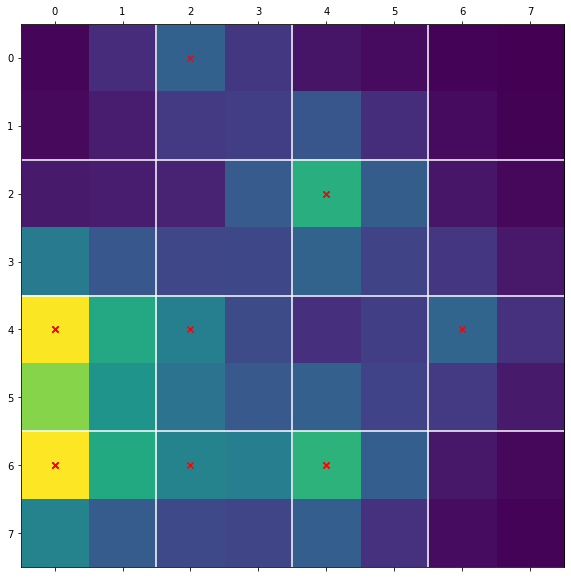

In [25]:
f, axarr = plt.subplots(1, 1, figsize=(10, 10))

# plot image
axarr.matshow(images[batch, band].cpu().detach())

# plot locations 
axarr.scatter(locs_full[batch, :, 1].cpu() * slen - 0.5, 
              locs_full[batch, :, 0].cpu() * slen - 0.5, 
              color = 'red', marker = 'x')

# draw white lines
for i in range(int(slen / tile_slen)): 
    axarr.axvline(tile_slen * i - 0.5, color = 'white')
    axarr.axhline(tile_slen * i - 0.5, color = 'white')
    

# One last check: 

Reconstruct the image with the full-parameterization and the full image equal to one tile. 

In other words, this decoder has `slen = tile_slen`, so the tile is the full image. 

We will pass in the full-image parameters to this encoder

In [26]:
image_decoder2 = ImageDecoder(dec,
                        psf_params,
                        background,
                        n_bands=n_bands,
                        slen=slen,
                        tile_slen=slen,
                        prob_galaxy=prob_galaxy,
                        max_sources_per_tile=locs_full.shape[1],
                        mean_sources_per_tile=0.8,
                        min_sources_per_tile=0,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=False,)

In [27]:
image_decoder2.n_tiles_per_image

1

In [28]:
_n_sources = n_sources_full[batch].unsqueeze(0).unsqueeze(0)
_locs = locs_full[batch].unsqueeze(0).unsqueeze(0)
# galaxies are all off for now .. 
_galaxy_bool = torch.zeros(1, 1, image_decoder2.max_sources_per_tile, device = device)
_galaxy_params = galaxy_params_full[batch].unsqueeze(0).unsqueeze(0)
_fluxes = fluxes_full[batch].unsqueeze(0).unsqueeze(0)

image2 = image_decoder2.render_images(
                            _n_sources,
                            _locs,
                            _galaxy_bool,
                            _galaxy_params,
                            _fluxes)
# image2 = image2[:, 0, :, 16:32, 16:32] + background.unsqueeze(0)

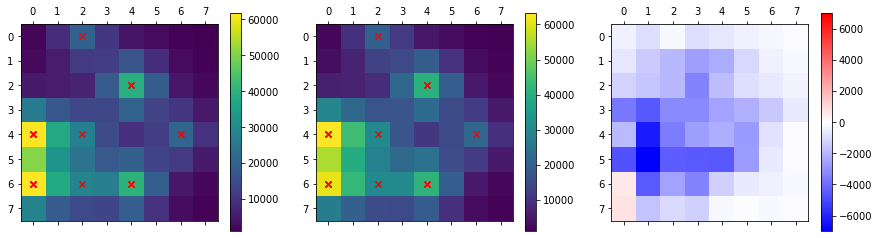

In [29]:
f, axarr = plt.subplots(1, 3, figsize=(15, 4))

# plot tile-constructed image
ax0 = axarr[0].matshow(images[batch, band].cpu().detach())
f.colorbar(ax0, ax = axarr[0])

# plot image constructed from full parameterization
ax1 = axarr[1].matshow(image2[0, band].cpu().detach())
f.colorbar(ax1, ax = axarr[1])

# plot difference
diff = (images[batch, band] - image2[0, band]).cpu().detach()
vmax = diff.abs().max()
ax2 = axarr[2].matshow(diff, vmax = vmax, vmin = -vmax,
                 cmap = plt.get_cmap('bwr'))
f.colorbar(ax2, ax = axarr[2])

# plot locations 
for i in range(2): 
    n = _n_sources.squeeze().long()
    axarr[i].scatter(locs_full[batch, 0:n, 1].cpu() * slen - 0.5, 
                  locs_full[batch, 0:n, 0].cpu() * slen - 0.5, 
                  color = 'red', marker = 'x')